# Notebook: Data validation

Sensor data quality plays a vital role in Internet of Things (IoT) applications as they are rendered useless if the data quality is bad.

The second most commonly found error in sensor data is missing data. missing data is caused by various factors such as unstable wireless connection due to network congestion, sensor device outages due to its limited battery life, environmental interferences e.g. human blockage, walls, and weather conditions, and malicious attacks. There are cases where sensor data is missing for extended periods of time, which might lead to incorrect decision making on the consumer side. 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sbn
sbn.set()

## Load the PHMDataset2018 dataset

In [3]:
from ceruleo.dataset.catalog.PHMDataset2018 import PHMDataset2018, FailureType

2022-08-08 21:13:12.298907: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/luciano/venvs/ceruleo/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dataset = PHMDataset2018(
    tools=['01_M01', '04_M01']
)

### Create a transformer for a dataset

In [5]:
from ceruleo.dataset.analysis.numerical_features import analysis
from ceruleo.transformation.functional.transformers import Transformer
from ceruleo.transformation.features.selection import ByNameFeatureSelector, ByTypeFeatureSelector
from ceruleo.iterators.iterators import RelativeToEnd
from ceruleo.transformation.features.slicing import SliceRows
from ceruleo.transformation.functional.pipeline.pipeline import make_pipeline
from ceruleo.transformation.features.resamplers import IndexMeanResampler
from ceruleo.transformation.features.transformation import Clip
from ceruleo.transformation.features.slicing import SliceRows
from ceruleo.iterators.iterators import RelativeToEnd

In [6]:
FEATURES = [
   'IONGAUGEPRESSURE', 'ETCHBEAMVOLTAGE', 'ETCHBEAMCURRENT',
   'ETCHSUPPRESSORVOLTAGE', 'ETCHSUPPRESSORCURRENT', 'FLOWCOOLFLOWRATE',
   'FLOWCOOLPRESSURE', 'ETCHGASCHANNEL1READBACK', 'ETCHPBNGASREADBACK',
]
transformer = Transformer(
    pipelineX=make_pipeline(
        ByNameFeatureSelector(features=FEATURES), 
        Clip(lower=-6, upper=6),
        IndexMeanResampler(rule='120s'),
        SliceRows(initial=RelativeToEnd(1500))
    ), 
    pipelineY=make_pipeline(
        ByNameFeatureSelector(features=['RUL']),  
        IndexMeanResampler(rule='120s'),
        SliceRows(initial=RelativeToEnd(1500))
    )
)

transformed_dataset = transformer.fit_map(dataset)

(array([ 1.,  1.,  0.,  0.,  1.,  2.,  0.,  0.,  2., 15.]),
 array([ 155. ,  289.5,  424. ,  558.5,  693. ,  827.5,  962. , 1096.5,
        1231. , 1365.5, 1500. ]),
 <BarContainer object of 10 artists>)

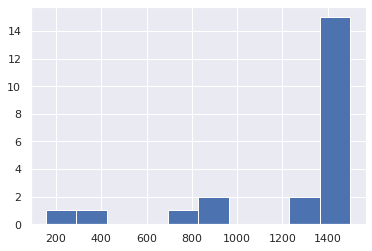

In [7]:
plt.hist([life[0].shape[0] for life in transformed_dataset])

## Sample rate

We can evalute the sample rate of the dataset without transformation. We can see that there are huge variations of the sample rate, but the vast majority of points are sampled after 4 seconds.

In [8]:
from ceruleo.dataset.analysis.sample_rate import sample_rate, sample_rate_summary

(0.0, 10.0)

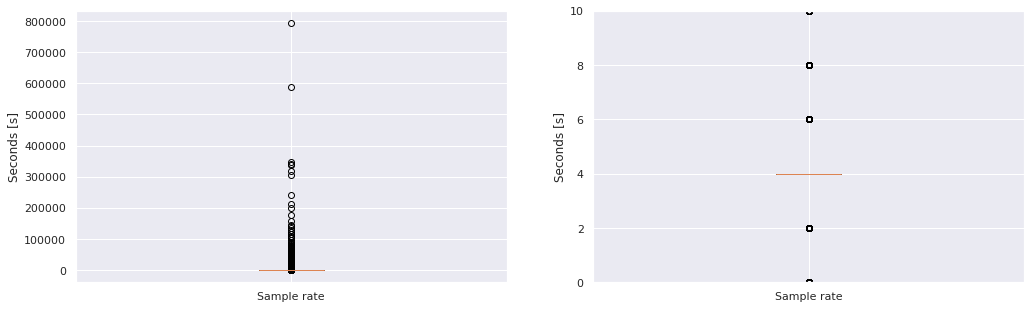

In [9]:
sample_rates = sample_rate(dataset)
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
ax[0].boxplot(sample_rates, labels=['Sample rate'])
ax[0].set_ylabel('Seconds [s]')

ax[1].boxplot(sample_rates, labels=['Sample rate'])
ax[1].set_ylabel('Seconds [s]')
ax[1].set_ylim(0, 10)

In [10]:
sample_rate_summary(dataset)

,Mean sample rate,Std sample rate,Mode sample rate
Dataset,10.107057,607.609879,4.0


## Missing values
Usually, the information of sensors is incomplete and this causes numerous missing values in the features. This library provides some useful functions to analyse the proportion of the missing values for each feature for each life. In some cases, if the feature values are missing in multiple lives, that feature can be discarded.

In [11]:
analysis(transformed_dataset, what_to_compute=['null'])

,null Mean,null Max,null Min
IONGAUGEPRESSURE,0.0+/-0,0.0,0.0
ETCHBEAMVOLTAGE,0.0+/-0,0.0,0.0
ETCHBEAMCURRENT,0.0+/-0,0.0,0.0
ETCHSUPPRESSORVOLTAGE,0.0+/-0,0.0,0.0
ETCHSUPPRESSORCURRENT,0.0+/-0,0.0,0.0
FLOWCOOLFLOWRATE,0.0+/-0,0.0,0.0
FLOWCOOLPRESSURE,0.0+/-0,0.0,0.0
ETCHGASCHANNEL1READBACK,0.0+/-0,0.0,0.0
ETCHPBNGASREADBACK,0.0+/-0,0.0,0.0


## Pairwise correlation

In [12]:
from ceruleo.dataset.analysis.correlation import correlation_analysis

In [13]:
(correlation_analysis(transformed_dataset, corr_threshold=0.7)
 .sort_values(by='Abs mean correlation', ascending=False)
 .head(15)
)

Mean Correlation  \
Feature 1               Feature 2                                   
ETCHBEAMCURRENT         ETCHSUPPRESSORCURRENT            0.991056   
                        ETCHBEAMVOLTAGE                  0.987921   
ETCHGASCHANNEL1READBACK IONGAUGEPRESSURE                 0.987111   
                        ETCHPBNGASREADBACK               0.982436   
ETCHPBNGASREADBACK      IONGAUGEPRESSURE                 0.981888   
ETCHBEAMVOLTAGE         ETCHSUPPRESSORCURRENT            0.979770   
ETCHPBNGASREADBACK      FLOWCOOLFLOWRATE                 0.976141   
ETCHGASCHANNEL1READBACK FLOWCOOLFLOWRATE                 0.967222   
FLOWCOOLFLOWRATE        IONGAUGEPRESSURE                 0.951432   
ETCHSUPPRESSORCURRENT   IONGAUGEPRESSURE                 0.940426   
ETCHBEAMCURRENT         IONGAUGEPRESSURE                 0.936632   
ETCHGASCHANNEL1READBACK ETCHSUPPRESSORCURRENT            0.936096   
ETCHBEAMCURRENT         ETCHGASCHANNEL1READBACK          0.933485   
ETCHBEAMVOLTAGE         ETCHGASCHANNEL1READBACK          0.924100   
ETCHPBNGASREADBACK      ETCHSUPPRESSORVOLTAGE            0.917120   

                                                 Std Correlation  \
Feature 1               Feature 2                                  
ETCHBEAMCURRENT         ETCHSUPPRESSORCURRENT           0.020119   
                        ETCHBEAMVOLTAGE                 0.006408   
ETCHGASCHANNEL1READBACK IONGAUGEPRESSURE                0.016922   
                        ETCHPBNGASREADBACK              0.008539   
ETCHPBNGASREADBACK      IONGAUGEPRESSURE                0.017535   
ETCHBEAMVOLTAGE         ETCHSUPPRESSORCURRENT           0.018522   
ETCHPBNGASREADBACK      FLOWCOOLFLOWRATE                0.009566   
ETCHGASCHANNEL1READBACK FLOWCOOLFLOWRATE                0.012392   
FLOWCOOLFLOWRATE        IONGAUGEPRESSURE                0.014617   
ETCHSUPPRESSORCURRENT   IONGAUGEPRESSURE                0.023765   
ETCHBEAMCURRENT         IONGAUGEPRESSURE                0.039110   
ETCHGASCHANNEL1READBACK ETCHSUPPRESSORCURRENT           0.029066   
ETCHBEAMCURRENT         ETCHGASCHANNEL1READBACK         0.045739   
ETCHBEAMVOLTAGE         ETCHGASCHANNEL1READBACK         0.046049   
ETCHPBNGASREADBACK      ETCHSUPPRESSORVOLTAGE           0.069759   

                                                 Percentage of lives with a high correlation  \
Feature 1               Feature 2                                                              
ETCHBEAMCURRENT         ETCHSUPPRESSORCURRENT                                     100.000000   
                        ETCHBEAMVOLTAGE                                           100.000000   
ETCHGASCHANNEL1READBACK IONGAUGEPRESSURE                                          100.000000   
                        ETCHPBNGASREADBACK                                        100.000000   
ETCHPBNGASREADBACK      IONGAUGEPRESSURE                                          100.000000   
ETCHBEAMVOLTAGE         ETCHSUPPRESSORCURRENT                                     100.000000   
ETCHPBNGASREADBACK      FLOWCOOLFLOWRATE                                          100.000000   
ETCHGASCHANNEL1READBACK FLOWCOOLFLOWRATE                                          100.000000   
FLOWCOOLFLOWRATE        IONGAUGEPRESSURE                                          100.000000   
ETCHSUPPRESSORCURRENT   IONGAUGEPRESSURE                                          100.000000   
ETCHBEAMCURRENT         IONGAUGEPRESSURE                                          100.000000   
ETCHGASCHANNEL1READBACK ETCHSUPPRESSORCURRENT                                     100.000000   
ETCHBEAMCURRENT         ETCHGASCHANNEL1READBACK                                   100.000000   
ETCHBEAMVOLTAGE         ETCHGASCHANNEL1READBACK                                   100.000000   
ETCHPBNGASREADBACK      ETCHSUPPRESSORVOLTAGE                                      95.454545   

                                                 Abs mean correlation  \
Feature 1   

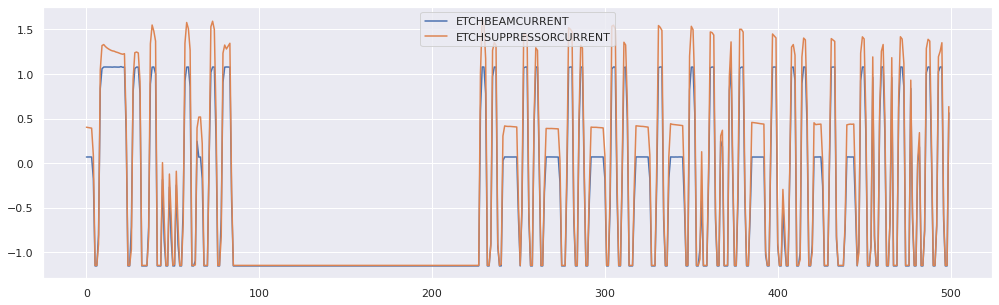

In [14]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(transformed_dataset.get_features_of_life(0)['ETCHBEAMCURRENT'].values[-500:],
        label='ETCHBEAMCURRENT')
ax.plot(transformed_dataset.get_features_of_life(0)['ETCHSUPPRESSORCURRENT'].values[-500:], 
        label='ETCHSUPPRESSORCURRENT')
ax.legend()

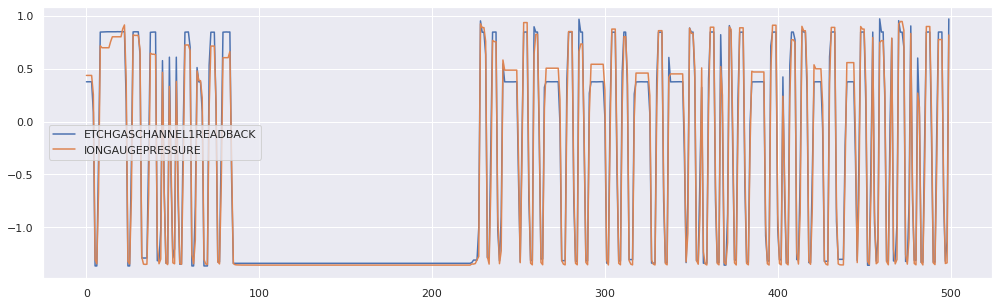

In [15]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(transformed_dataset.get_features_of_life(0)['ETCHGASCHANNEL1READBACK'].values[-500:],
        label='ETCHGASCHANNEL1READBACK')
ax.plot(transformed_dataset.get_features_of_life(0)['IONGAUGEPRESSURE'].values[-500:], 
        label='IONGAUGEPRESSURE')
ax.legend()

## Feature distribution

In [16]:
from ceruleo.dataset.analysis.distribution import features_divergeces

In [17]:

d = features_divergeces(transformed_dataset)

In [18]:
d.sort_values(by='KL', ascending=False).head(15)

,Life 1,Life 2,W,KL,feature
415,11,20,0.069388,3.828402,ETCHBEAMVOLTAGE
412,11,17,0.076889,3.820812,ETCHBEAMVOLTAGE
184,11,20,0.069388,3.797501,ETCHBEAMCURRENT
181,11,17,0.071822,3.794343,ETCHBEAMCURRENT
182,11,18,0.075378,3.790792,ETCHBEAMCURRENT
1339,11,20,0.070996,3.790263,ETCHSUPPRESSORVOLTAGE
646,11,20,0.075178,3.780445,ETCHGASCHANNEL1READBACK
643,11,17,0.079733,3.749477,ETCHGASCHANNEL1READBACK
413,11,18,0.069333,3.747244,ETCHBEAMVOLTAGE
416,11,21,0.075111,3.744968,ETCHBEAMVOLTAGE


In [19]:
def plot_distributions(ax, ds, life1, life2, feature):
    ax.hist(ds.get_features_of_life(life1)[feature],
        label=feature,
        density=True,
        alpha=0.5,
        bins=20)
    ax.hist(ds.get_features_of_life(life2)[feature], 
            label=feature,
            density=True,
            alpha=0.5,
            bins=20)
    ax.legend()
    
    
def plot_timeseries(ax, ds, life, feature):
    ax.plot(ds.get_features_of_life(life)[feature].values,
            alpha=0.5,
            label=feature)




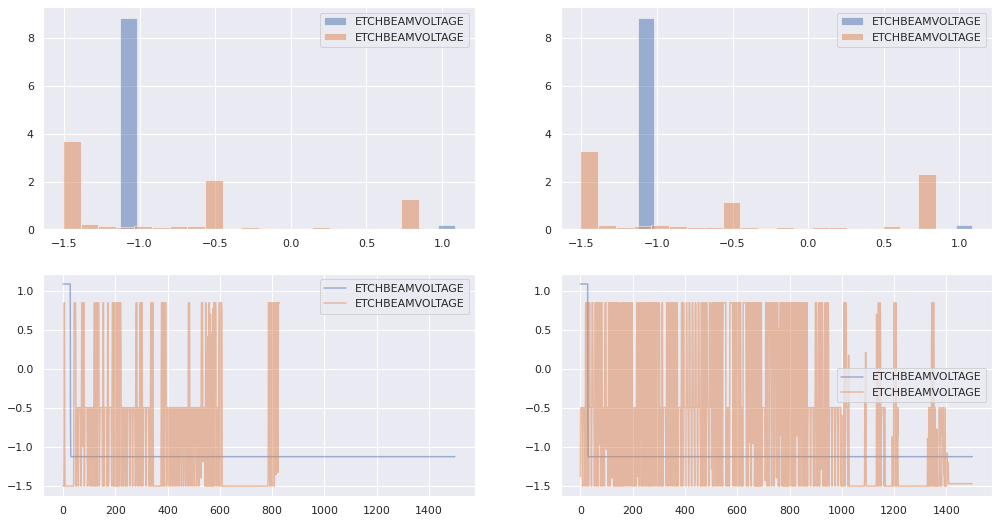

In [20]:
first_row = d.sort_values(by='KL', ascending=False).iloc[0, :]
feature = first_row['feature']
life1 = first_row['Life 1']
life2 = first_row['Life 2']
fig, ax = plt.subplots(2, 2, figsize=(17, 9))
plot_distributions(ax[0, 0], transformed_dataset, life1, life2, feature)

plot_timeseries(ax[1, 0], transformed_dataset, life1, feature )
plot_timeseries(ax[1, 0], transformed_dataset, life2, feature )
ax[1, 0].legend()


first_row = d.sort_values(by='KL', ascending=False).iloc[1, :]
feature = first_row['feature']
life1 = first_row['Life 1']
life2 = first_row['Life 2']
plot_distributions(ax[0, 1], transformed_dataset, life1, life2, feature)


plot_timeseries(ax[1, 1], transformed_dataset, life1, feature )
plot_timeseries(ax[1, 1], transformed_dataset, life2, feature )
ax[1, 1].legend()

In [21]:
d.sort_values(by='W', ascending=False).head(5)

,Life 1,Life 2,W,KL,feature
991,3,11,0.097962,2.715986,ETCHSUPPRESSORCURRENT
1109,11,21,0.096444,2.924457,ETCHSUPPRESSORCURRENT
1106,11,18,0.093244,2.632462,ETCHSUPPRESSORCURRENT
1104,11,16,0.091556,1.495353,ETCHSUPPRESSORCURRENT
1101,11,13,0.091556,2.373566,ETCHSUPPRESSORCURRENT


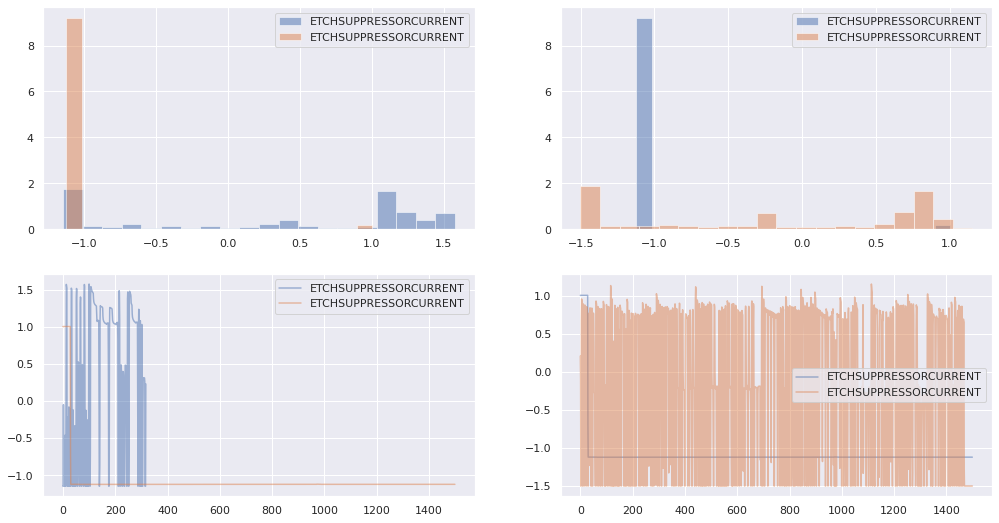

In [22]:
first_row = d.sort_values(by='W', ascending=False).iloc[0, :]
feature = first_row['feature']
life1 = first_row['Life 1']
life2 = first_row['Life 2']
fig, ax = plt.subplots(2, 2, figsize=(17, 9))
plot_distributions(ax[0, 0], transformed_dataset, life1, life2, feature)

plot_timeseries(ax[1, 0], transformed_dataset, life1, feature )
plot_timeseries(ax[1, 0], transformed_dataset, life2, feature )
ax[1, 0].legend()


first_row = d.sort_values(by='W', ascending=False).iloc[1, :]
feature = first_row['feature']
life1 = first_row['Life 1']
life2 = first_row['Life 2']
plot_distributions(ax[0, 1], transformed_dataset, life1, life2, feature)


plot_timeseries(ax[1, 1], transformed_dataset, life1, feature )
plot_timeseries(ax[1, 1], transformed_dataset, life2, feature )
ax[1, 1].legend()